# Community detection to define response profile subtypes on the Conners-3 questionnaire

Loading the required packages

In [43]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [44]:
import sys
sys.path.append('/home/jb07/nipype_installation/')

In [46]:
import bct
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
from numpy import random
from scipy.stats import chisquare, mannwhitneyu, shapiro, ttest_ind, sem, zscore
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.formula.api import ols
import seaborn as sns
import pandas as pd

Definitions of plotting parameters 

In [ ]:
from IPython.display import display
from ipywidgets import interact

In [47]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 90*mm2inches
double_column = 190*mm2inches
one_half_column = 140*mm2inches

In [48]:
outfolder = '/imaging/jb07/CALM/Behavioural/Community_Detection/'

## Function definitions

Functions for analysis

In [ ]:
def construct_network(df):
    #================================
    # Convenience function to create a network based on the correlation 
    # between behavioural measures after regressing age
    #================================
    """
    inputs:
    df: pandas dataframe with behavioural measures and age
    
    outputs:
    dataframe with age-regressed behavioural measures
    matrix of correlation between age-regressed behavioural measures
    """
    
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from statsmodels.formula.api import ols

    variables = [col for col in df.columns if col not in ['age']]

    # Scaling the variables
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[df.columns]), columns=df.columns)

    # Regressing the effect of age
    df_woAge = df_scaled.copy()
    for variable in variables:
        df_woAge[variable] = ols(variable + ' ~ age', data=df_scaled).fit().resid

    network = df_woAge[variables].transpose().corr().values

    return (network, df_woAge)

def get_consensus_module_assignment(network, iterations):
    #================================
    # Obtain the consensus module structure
    #================================
    """
    inputs:
    adjacency_matrix: adjacency_matrix
    gamma: gamma value

    outputs:
    vector of module assignment for each node
    """
    import numpy as np
    consensus_matrices = list()

    for i in range(0,iterations):
        consensus_matrix,modules,q = get_consensus_matrix(network)
        consensus_matrices.append(consensus_matrix)

    mean_consensus_matrix = np.mean(consensus_matrices,axis=0)

    consensus_matrix,modules,q = get_consensus_matrix(mean_consensus_matrix)
    consensus_matrix2,modules,q = get_consensus_matrix(mean_consensus_matrix)

    while abs(np.sum(consensus_matrix - consensus_matrix2)) != 0:
        consensus_matrix,modules,q = get_consensus_matrix(mean_consensus_matrix)
        consensus_matrix2,modules,q = get_consensus_matrix(mean_consensus_matrix)

    return (modules, q)

def get_consensus_matrix(network):
    # Helper function for consensus clustering
    
    import bct
    import numpy as np
    modules,q = bct.modularity_louvain_und_sign(network, qtype='smp')
    module_matrix = np.repeat(modules,repeats=network.shape[0])
    module_matrix = np.reshape(module_matrix,newshape=network.shape)
    consensus_matrix = module_matrix == module_matrix.transpose()
    return (consensus_matrix.astype('float'), modules, q)

Plotting functions

In [ ]:
def plot_network(network):
    import matplotlib.pyplot as plt

    plt.imshow(network, 
               cmap='jet',
               interpolation='none',
               vmin=-1, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar()
    cb.set_label('Pearson correlation coefficient R')
    cb.ax.yaxis.set_label_position('left')

def plot_community_matrix(network, community_affiliation, cmap):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    sorting_array = sorted(range(len(community_affiliation)), key=lambda k: community_affiliation[k])
    sorted_network = network[sorting_array, :]
    sorted_network = sorted_network[:, sorting_array]
    plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=600)
    im = plt.imshow(sorted_network, 
               cmap=cmap,
               interpolation='none',
               vmin=-1, vmax=1)
    plt.axis('off')
    ax = plt.gca()
    ax.grid('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label('Pearson correlation coefficient R')
    cb.ax.yaxis.set_label_position('right')
    plt.tight_layout(pad=0, w_pad=1, h_pad=0)

    
def plot_spring_network(network, community_affiliation, colours):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    
    plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=600)
    G=nx.from_numpy_matrix(bct.threshold_absolute(network, 0.8))

    pos=nx.spring_layout(G)

    for community in np.unique(community_affiliation):

        nx.draw_networkx_nodes(G,pos,
                               nodelist=np.where(community_affiliation == community)[0].tolist(),
                               node_color=colours[community-1],
                               node_size=20,
                               alpha=0.8)


    nx.draw_networkx_edges(G,pos,width=0.5,alpha=0.5)
    plt.axis('off');
    #plt.legend(['C' + str(community) for community in np.unique(community_affiliation) ])
    

def make_SuePlot(df, measures, labels, size, name, binarized_results, colours, bwr, legend):
    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                   'font.family': [u'serif'],
                   'font.sans-serif': [u'Computer Modern Unicode'],})
    styles = [['x', 'dashed'], ['o', 'solid'], ['+', 'dotted']]

    fig = plt.figure(figsize=(size[0], size[1]), dpi=600)

    plt.subplot(2,1,1)
    for community in np.unique(df['groups'].values):
        plt.errorbar(x=range(0,len(measures)),
                y=df[df['groups'] == community][measures].mean().values,
                yerr=2*df[df['groups'] == community][measures].std().values/sqrt(len(df[df['groups'] == community])),
                color=colours[community-1],
                marker=styles[community-1][0],
                linestyle=styles[community-1][1])

    plt.xlim([-0.5,len(measures)-0.5])
    plt.xticks(range(0,len(measures)))
    if legend == 1:
        plt.legend(['C' + str(community) for community in sorted(np.unique(community_affiliation))], frameon=True, loc='best')
    plt.ylabel('z-score residuals')
    ax = plt.gca()
    ax.set_xticklabels('', rotation=90);
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.subplot(2,1,2)
    combinations = list(itertools.combinations(np.unique(community_affiliation), 2))

    new_style = {'grid': False}
    matplotlib.rc('axes', **new_style)
    if bwr == 0:
        plt.imshow(binarized_results, 
                  interpolation = 'none', 
                  cmap=LinearSegmentedColormap.from_list('mycmap', [(0, 'lightgray'), (1, 'orangered')]))
    if bwr == 1:
        plt.imshow(binarized_results, 
                  interpolation = 'none', 
                  cmap=LinearSegmentedColormap.from_list('mycmap', [(0, 'white'), (1, 'darkgray')]))
    plt.yticks(np.arange(0,len(combinations)))
    plt.xticks(np.arange(0, len(measures)))
    plt.ylabel('contrast results')

    ax = plt.gca()
    ax.set_yticklabels([str(combination[0]) + ' v ' + str(combination[1]) for combination in combinations], rotation=0);
    ax.set_xticklabels(labels, rotation=90);
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.savefig(outfolder + 'Sue_plot' + name + '.png', dpi=600)
    

Functions for robustness testing

In [49]:
def add_noise(network, percentage_noise):
    import numpy as np

    network_wNoise = (1-(float(percentage_noise)/100))*network + (float(percentage_noise)/100)*np.random.normal(0, 1, network.shape)

    return network_wNoise

def get_connection_densities(network, community_affiliation):
    #================================
    # Get density of within and between module connections
    #================================
    """
    inputs:
    network: adjacency_matrix (NumPy array)
    community_affiliation: array that indicates which community/module an node belongs to

    outputs:
    density of connections within modules
    density of connections between modules
    """

    import networkx as nx
    
    network[network > 0] = 1. # binarizing the network
    
    G = nx.from_numpy_matrix(network) # original network
    for node in G.nodes():
         G.node[node]['community'] = community_affiliation[node]

    within_weights = list()
    between_weights = list()

    for edge in G.edges():
        if G.node[edge[0]]['community'] == G.node[edge[1]]['community']:
            within_weights.append(G.edge[edge[0]][edge[1]]['weight'])
        else:
            between_weights.append(G.edge[edge[0]][edge[1]]['weight'])

    connected_G = nx.from_numpy_matrix(np.ones(shape=network.shape)) # fully-connected network
    full_within_weights = list()
    full_between_weights = list()

    for node in connected_G.nodes():
         connected_G.node[node]['community'] = community_affiliation[node]

    for edge in connected_G.edges():
        if connected_G.node[edge[0]]['community'] == connected_G.node[edge[1]]['community']:
            full_within_weights.append(connected_G.edge[edge[0]][edge[1]]['weight'])
        else:
            full_between_weights.append(connected_G.edge[edge[0]][edge[1]]['weight'])

    within_density = sum(within_weights)/sum(full_within_weights)
    between_density = sum(between_weights)/sum(full_between_weights)
    
    return(within_density, between_density)

### Analysis

Loading the data

In [50]:
df = pd.read_csv(outfolder + 'CALM_behavioural_data_Apr17.csv')
print('Number of children assessed: ' + str(len(df['ID No.'].dropna())))

Number of children assessed: 462


In [51]:
df = pd.read_csv(outfolder + 'CALM_behavioural_data_Apr17.csv')
df = df[['ID No.','Gender(1=male)', 'Age_in_months', 
        'Conners_inattention_raw',
        'Conners_hyperactivity_impulsivity_raw',
        'Conners_learning_problems_raw',
        'Conners_ExecutiveFunction_raw',
        'Conners_agression_raw',
        'Conners_PeerRelations_raw',
        'Conners_Positive_Impression',
        'Connors_Negative_Impression']]

df.columns = ['ID', 'gender', 'age',
              'Inattention',
              'HyperactImpuls',
              'LearnProb',
              'ExeFunc',
              'Aggression',
              'PeerRel',
              'PosImp',
              'NegImp']

#### Forcing numeric variables to numeric format

In [52]:
variables = df.columns[2:].values

for variable in variables: 
    df[variable] = df[variable].astype(str).convert_objects(convert_numeric=True)

/home/jb07/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


#### Removing missing values

In [53]:
df = df.replace(999,float('nan'))
df = df.replace('incomplete',float('nan'))
df = df.replace('INCOMPLETE',float('nan'))
df = df.replace('.',float('nan'))
df = df.dropna()
print('Number of children with complete data on Conners-3: ' + str(len(df['ID'])))

Number of children with complete data on Conners-3: 442


Assessing validity scales

In [54]:
print('Possibly overly positive response style: ' + str(sum(df['PosImp'].values > 3)))
print('Possibly overly negative response style: ' + str(sum(df['NegImp'].values > 3)))

Possibly overly positive response style: 0
Possibly overly negative response style: 80


In [55]:
network,df_woAge = construct_network(df[['age', 'Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']])
df_woAge['ID']  = df['ID']
df_woAge['gender'] = df['gender']

In [56]:
print('Number of children included in the analysis: ' + str(len(df)) + 
      ' (M:' + str(len(df_woAge[df_woAge['gender'] == 1])) + 
      '; F:' + str(len(df_woAge[df_woAge['gender'] == 2])) + ')')

print('Age: mean=' + 
    str(round(df['age'].mean(), 2)) + 
    '; SE=' +
    str(round(sem(df['age']), 3)) + 
    '; Range=' + 
    str(round(df['age'].min(), 2)) + '-' +
    str(round(df['age'].max(), 2)))

Number of children included in the analysis: 442 (M:295; F:135)
Age: mean=110.27; SE=1.261; Range=2.0-215.0


#### Community detection to define subgroups

In [ ]:
community_affiliation,q = get_consensus_module_assignment(network, 100)
print('Quality index:' + str(round(q,2)))

In [16]:
df['groups'] = community_affiliation
df.to_csv(outfolder + '/Behavioural_data_grouped_Apr17_revision.csv')

**Control analysis**: excluding the ratings with high negativity

In [ ]:
neg_excluded_df = df.copy()
neg_excluded_df = neg_excluded_df[neg_excluded_df['NegImp'] < 3]
network_negEx,df_negEx_woAge = construct_network(neg_excluded_df[['age', 'Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']])
community_affiliation,q = get_consensus_module_assignment(network_negEx, 100)
print('Quality index:' + str(round(q,2)))

Selecting a random subset of the full sample

In [17]:
subsample_df = df[df['ID'].isin(np.random.choice(df['ID'].values, int(.25*len(df))))]
network_samp,df_negEx_samp = construct_network(subsample_df[['age', 'Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']])
community_affiliation,q = get_consensus_module_assignment(network_negEx, 100)
print('Quality index:' + str(round(q,2)))

Quality index:0.59


##### Plotting the results

/home/jb07/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


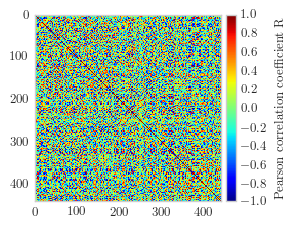

In [169]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=300)
im = plt.imshow(network, 
           cmap='jet',
           interpolation='none',
           vmin=-1, vmax=1)
ax = plt.gca()
ax.grid('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('Pearson correlation coefficient R')
cb.ax.yaxis.set_label_position('right')
plt.tight_layout(pad=0, w_pad=1, h_pad=0)
plt.savefig(outfolder + 'native_matrix.png', dpi=300)

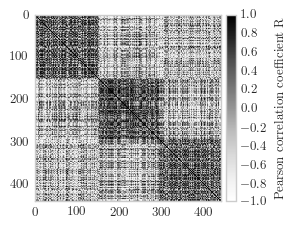

In [170]:
plot_community_matrix(network, community_affiliation, 'Greys')
plt.savefig(outfolder + 'community_matrix_bwr.png', dpi=600)

**Figure**: Adjacency matrix after ordering nodes according to the community assignment. The adjacency matrix shows a clear separation of communities as indicated by the distinct rectangles along the diagonal. 

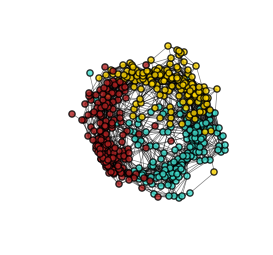

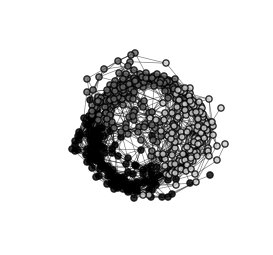

In [31]:
colours = ['turquoise', 'gold', 'firebrick']
plot_spring_network(network, community_affiliation, colours)
plt.savefig(outfolder + 'spring_layout.png', dpi=600)

colours = ['black', 'dimgray', 'lightgray']
plot_spring_network(network, community_affiliation, colours)
plt.savefig(outfolder + 'spring_layout_bwr.png', dpi=600)

In [66]:
df = pd.read_csv(outfolder + '/Behavioural_data_grouped_Apr17_revision.csv')
community_affiliation = df['groups'].values
network = df[measures].transpose().corr().values

**Figure**: Visualization of community detection. The figure shows the three communities detected by the algorithm. The network is plotted in a spring layout and was thresholded at 0.6 for visualization purposes.

### Stats

Getting descriptives for the group assignment

In [17]:
df_woAge['groups'] = community_affiliation

In [18]:
print('Cluster 1: ' + str(len(df_woAge[df_woAge['groups'] == 1])) + '(' + str(round(100*float(len(df_woAge[df_woAge['groups'] == 1]))/len(df_woAge), 2)) + '%)')
print('Cluster 2: ' + str(len(df_woAge[df_woAge['groups'] == 2])) + '(' + str(round(100*float(len(df_woAge[df_woAge['groups'] == 2]))/len(df_woAge), 2)) + '%)')
print('Cluster 3: ' + str(len(df_woAge[df_woAge['groups'] == 3])) + '(' + str(round(100*float(len(df_woAge[df_woAge['groups'] == 3]))/len(df_woAge), 2)) + '%)')

Cluster 1: 149(33.71%)
Cluster 2: 144(32.58%)
Cluster 3: 149(33.71%)


In [19]:
print('Connection density within modules: ' + str(round(get_connection_densities(network, community_affiliation)[0], 2)))
print('Connection density outside modules: ' + str(round(get_connection_densities(network, community_affiliation)[1], 2)))

Connection density within modules: 0.79
Connection density outside modules: 0.05


Checking the distribution of scores in each group

In [20]:
for variable in variables[1:-2]:
    print(variable + ': p=' + str(round(shapiro(df_woAge[df_woAge['groups'] == 1][variable])[1], 3)))

Inattention: p=0.0
HyperactImpuls: p=0.0
LearnProb: p=0.017
ExeFunc: p=0.0
Aggression: p=0.0
PeerRel: p=0.0


Creating a data frame with the data in long format for plotting and statistics 

In [21]:
df_woAge['groups'] = community_affiliation
df_long = pd.melt(df_woAge, id_vars=['ID','age', 'gender', 'groups'])
df_long['variable'] = pd.Categorical(df_long['variable'].values, categories=df_woAge.columns[1:-3].values, ordered=True)

Contrasts with Mann-WhitneyU and Bonferroni correction:

In [22]:
combinations = list(itertools.combinations(np.unique(community_affiliation), 2))
corrected_results = [np.asarray([round(mannwhitneyu(df_woAge[df_woAge['groups'] == combinations[i][0]][variable], df_woAge[df_woAge['groups'] == combinations[i][1]][variable])[1]*len(combinations)*len(df_woAge.columns[1:-3]), 3) for variable in df_woAge.columns[1:-3]]) for i in range(0,len(combinations))]
stat_results = [np.asarray([round(mannwhitneyu(df_woAge[df_woAge['groups'] == combinations[i][0]][variable], df_woAge[df_woAge['groups'] == combinations[i][1]][variable])[0], 0) for variable in df_woAge.columns[1:-3]]) for i in range(0,len(combinations))]
binarized_results = np.vstack([corrected_results < 0.05 for corrected_results in corrected_results])

In [212]:
results = pd.DataFrame()
results['median1'] = df_woAge.groupby('groups').median().round(2)[variables[1:-2]].transpose().values[:,0]
results['mad1'] = df_woAge.groupby('groups').mad().round(3)[variables[1:-2]].transpose().values[:,0]
results['median2'] = df_woAge.groupby('groups').median().round(2)[variables[1:-2]].transpose().values[:,1]
results['mad2'] = df_woAge.groupby('groups').mad().round(3)[variables[1:-2]].transpose().values[:,1]
results['median3'] = df_woAge.groupby('groups').median().round(2)[variables[1:-2]].transpose().values[:,2]
results['mad3'] = df_woAge.groupby('groups').mad().round(3)[variables[1:-2]].transpose().values[:,2]
results['U1'] = stat_results[0]
results['p1'] = corrected_results[0]
results['U2'] = stat_results[1]
results['p2'] = corrected_results[1]
results['U3'] = stat_results[2]
results['p3'] = corrected_results[2]
print(results.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &  median1 &   mad1 &  median2 &   mad2 &  median3 &   mad3 &     U1 &     p1 &    U2 &     p2 &    U3 &     p3 \\
\midrule
0 &     0.02 &  0.935 &    -0.13 &  0.858 &     0.71 &  0.416 &  10062 &  2.786 &  6539 &  0.000 &  5159 &  0.000 \\
1 &     0.49 &  0.839 &    -0.86 &  0.637 &     0.62 &  0.607 &   4980 &  0.000 &  9623 &  0.522 &  2962 &  0.000 \\
2 &    -0.58 &  0.891 &     0.70 &  0.582 &    -0.04 &  0.702 &   4180 &  0.000 &  8656 &  0.012 &  5313 &  0.000 \\
3 &     0.07 &  0.958 &    -0.17 &  0.830 &     0.55 &  0.601 &  10167 &  3.452 &  7817 &  0.000 &  6536 &  0.000 \\
4 &     0.44 &  1.083 &    -0.63 &  0.535 &    -0.52 &  0.448 &   5385 &  0.000 &  6010 &  0.000 &  9452 &  0.702 \\
5 &     0.71 &  0.941 &    -0.37 &  0.693 &    -0.53 &  0.613 &   6368 &  0.000 &  5664 &  0.000 &  9664 &  1.275 \\
\bottomrule
\end{tabular}



In [213]:
measures = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
labels = measures

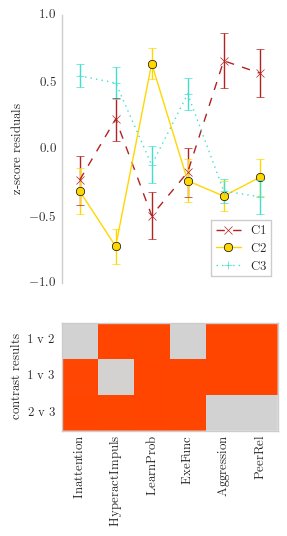

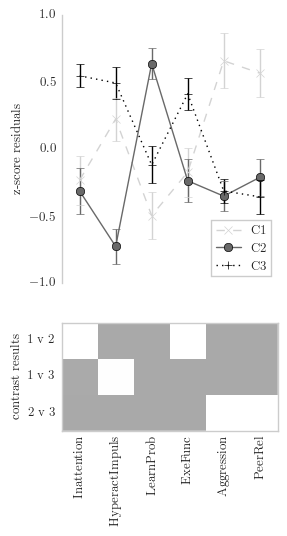

In [221]:
colours = ['firebrick', 'gold', 'turquoise']
make_SuePlot(df_woAge, measures, measures, [68*mm2inches, 140*mm2inches], 'R1', binarized_results, colours, 0)

colours = ['lightgray', 'dimgray', 'black']
make_SuePlot(df_woAge, measures, measures, [68*mm2inches, 140*mm2inches], 'R1_bwr', binarized_results, colours, 1)

### Robustness testing
Here, the robustness of the community assignment is tested by adding increasing amounts of random Gaussian noise to the network matrix.

In [30]:
quality_indices = list()
max_percent = 100

for percentage in np.arange(0,max_percent,5):
    network_wNoise = add_noise(network, percentage)
    try:
        community_affiliation,q = get_consensus_module_assignment(network_wNoise, 100)
        quality_indices.append(q)
    except:
        quality_indices.append(float('nan'))

In [ ]:
plt.figure(figsize=(single_column, 82*mm2inches), dpi=300)
plt.plot(np.arange(0,max_percent,5), np.nan_to_num(quality_indices), '-o', linewidth=3)
plt.xticks(np.arange(0,max_percent,10))
plt.xlabel('Added noise [\%]')
plt.ylim([0,1])
plt.ylabel(r'Quality index [\textit{Q}]')
ax = plt.gca()
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tight_layout(pad=1, w_pad=0, h_pad=0)
plt.savefig('/imaging/jb07/CALM/Behavioural/Community_Detection/Added_noise.png', dpi=300)

## Comparing severities on standardised scores

The grouping in the community detection analysis was based on raw scores after regressing age. In order to determine if the groups are within clinical ranges according to the normative data of the questionnaire, the groups are compared on their T scores here

In [222]:
std_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Apr17.csv')
std_df = std_df[['ID No.',
        'Conners_inattention_T',
        'Conners_hyperactivity_impulsivity_T',
        'Conners_learning_problems_T',
        'Conners_ExecutiveFunction_T',
        'Conners_agression_T',
        'Conners_PeerRelations_T']]

std_df.columns = ['ID',
              'Inattention_T',
              'HyperactImpuls_T',
              'LearnProb_T',
              'ExeFunc_T',
              'Aggression_T',
              'PeerRel_T']

std_df = std_df.dropna()

In [223]:
df_woAge = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')
std_df = pd.merge(df_woAge, std_df, on='ID')
std_df = std_df[['ID', 'groups', 'Inattention_T', 'HyperactImpuls_T', 'LearnProb_T', 'ExeFunc_T', 'Aggression_T', 'PeerRel_T']]
std_df = std_df.replace({r"[>=<]":90}, regex=True)

variables = std_df.columns[2:].values
for variable in variables: 
    std_df[variable] = std_df[variable].astype(str).convert_objects(convert_numeric=True)

/home/jb07/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [224]:
colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'blueviolet']
scales = ['Inattention_T', 'HyperactImpuls_T', 'LearnProb_T', 'ExeFunc_T', 'Aggression_T', 'PeerRel_T']
std_df['average'] = std_df[scales].mean(axis=1)

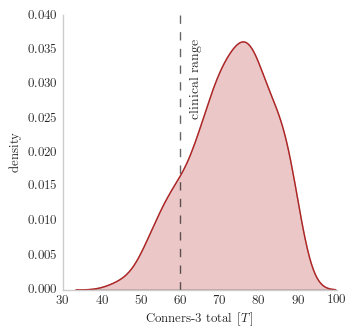

In [226]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

fig = plt.figure(num=None, figsize=(single_column, single_column), dpi=300, facecolor='white')
"""
counter = 0
for scale in scales:
    sns.kdeplot(std_df[scale], shade=True, color=colours[counter], alpha=0.6)
    counter += 1
"""
sns.kdeplot(std_df['average'], shade=True, color='firebrick')
#plt.legend(['Inatt', 'Hyperact/Impul', 'LearnProb', 'ExecFun', 'Agg', 'PeerPr'], loc='best')
plt.legend([' '])
plt.axvline(60, color='k', linestyle='dashed', alpha=0.6)
plt.text(62, 0.035, 'clinical range', rotation=90)
plt.xlabel(u'Conners-3 total [$T$]')
plt.ylabel('density')
ax = fig.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#plt.show()
plt.savefig('/home/jb07/Desktop/Conners_collapsed.png', dpi=600)

In [227]:
scales = ['Inattention_T', 'HyperactImpuls_T', 'LearnProb_T', 'ExeFunc_T', 'Aggression_T', 'PeerRel_T']
summary_df = pd.DataFrame(std_df[scales].mean().round(2), columns=['mean'])
summary_df['std'] = std_df[scales].std().round(3)
summary_df['min'] = std_df[scales].min()
summary_df['max'] = std_df[scales].max()
summary_df['T>65'] = np.sum(std_df[scales] > 60)
summary_df['T>65 percent'] = 100*(np.sum(std_df[scales] > 60)/len(std_df)).round(3)

In [228]:
print(summary_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &   mean &     std &  min &  max &  T>65 &  T>65 percent \\
\midrule
Inattention\_T    &  79.74 &  11.955 &   40 &   90 &   398 &          90.0 \\
HyperactImpuls\_T &  72.87 &  16.388 &   40 &   90 &   315 &          71.3 \\
LearnProb\_T      &  75.95 &  11.912 &   42 &   90 &   390 &          88.2 \\
ExeFunc\_T        &  73.81 &  12.906 &   40 &   90 &   363 &          82.1 \\
Aggression\_T     &  62.95 &  17.268 &   34 &   90 &   205 &          46.4 \\
PeerRel\_T        &  71.94 &  17.973 &   44 &   90 &   290 &          65.6 \\
\bottomrule
\end{tabular}



In [229]:
results = pd.DataFrame()
group_comparisons = [(1,2), (1,3), (2,3)]
measures = [ 'Inattention_T', 'HyperactImpuls_T', 'LearnProb_T', 'ExeFunc_T', 'Aggression_T', 'PeerRel_T']

for measure in measures:
    for group_comparison in group_comparisons:
        t,p = ttest_ind(std_df[std_df['groups'] == group_comparison[0]][measure].values.astype('int'), std_df[std_df['groups'] == group_comparison[1]][measure].values.astype('int'))
        results.set_value(measure, str(group_comparison), p)

rej, p, alphaSidak, alphaBonferroni = multipletests(results.values.flatten(), alpha=0.05, method='bonferroni')
binarized_results = 1*(results.values < alphaBonferroni).transpose()

In [230]:
df_long = pd.melt(std_df, id_vars=['ID', 'groups'])
df_long['variable'] = pd.Categorical(df_long['variable'].values, categories=std_df.columns[2:].values, ordered=True)

In [237]:
measures = ['Inattention_T', 'HyperactImpuls_T', 'LearnProb_T', 'ExeFunc_T', 'Aggression_T', 'PeerRel_T']
labels = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
bwr = 1

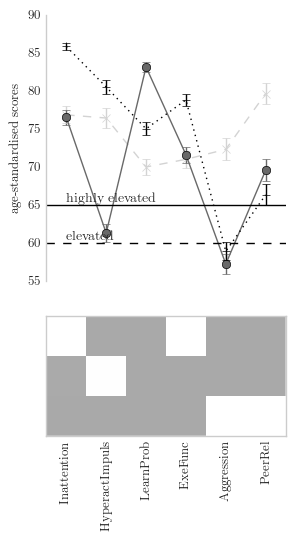

In [239]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
if bwr == 0:
    colours = ['firebrick', 'gold', 'turquoise']
if bwr == 1:
    colours = ['lightgray', 'dimgray', 'black']
    
styles = [['x', 'dashed'], ['o', 'solid'], ['+', 'dotted']]

plt.figure(figsize=(70*mm2inches, 140*mm2inches), dpi=600)

plt.subplot(2,1,1)
for community in np.unique(std_df['groups']):
    plt.errorbar(x=range(0,len(measures)),
                 y=std_df[std_df['groups'] == community][measures].mean().values,
                 yerr=std_df[std_df['groups'] == community][measures].std().values/sqrt(len(std_df[std_df['groups'] == 1])),
                 color=colours[community-1], 
                 marker=styles[community-1][0],
                 linestyle=styles[community-1][1])

#plt.legend(['C' + str(community) for community in np.unique(std_df['groups']) ], frameon=True, loc='best')

plt.axhline(y=65, linewidth=1, color='k', linestyle='solid')
plt.axhline(y=60, linewidth=1, color='k', linestyle='dashed')
plt.xlim([-0.5,len(df_woAge.columns[4:-3].values)-0.5])
plt.xticks(range(0,len(df_woAge.columns[4:-3].values)))
plt.text(0, 65.5, 'highly elevated')
plt.text(0, 60.5, 'elevated')
plt.ylabel('age-standardised scores')
ax = plt.gca()
ax.set_xticklabels('', rotation=90);
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.subplot(2,1,2)
combinations = list(itertools.combinations(np.unique(std_df['groups']), 2))
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
if bwr == 0:
    plt.imshow(binarized_results, 
              interpolation = 'none', 
              cmap=LinearSegmentedColormap.from_list('mycmap', [(0, 'lightgray'), (1, 'orangered')]))
if bwr == 1:
    plt.imshow(binarized_results, 
               interpolation = 'none', 
               cmap=LinearSegmentedColormap.from_list('mycmap', [(0, 'white'), (1, 'darkgray')]))    
plt.yticks(np.arange(0,len(combinations)))
plt.xticks(np.arange(0, len(measures)))
ax = plt.gca()
ax.set_yticklabels(' ')
ax.set_xticklabels(labels, rotation=90);
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
if bwr == 0:
    plt.savefig(outfolder + 'Sue_plot_standardised_R1.png', dpi=600)
if bwr == 1:
    plt.savefig(outfolder + 'Sue_plot_standardised_R1_bwr.png', dpi=600)

In [61]:
scales = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']

for scale in scales:
    mean = np.mean(std_df[scale + '_T'].values)
    std = np.std(std_df[scale + '_T'].values)
    number_elevated = np.sum(1*(std_df[scale + '_T'] > 60))
    percent_elevated = 100*(float(number_elevated))/len(std_df[scale + '_T'])
    
    print(scale)
    #print('mean=%.2f, std=%.3f' % (mean, std))
    print('Proportion: %.i (%.i)' % (number_elevated, percent_elevated))

Inattention
Proportion: 398 (90)
HyperactImpuls
Proportion: 315 (71)
LearnProb
Proportion: 390 (88)
ExeFunc
Proportion: 363 (82)
Aggression
Proportion: 205 (46)
PeerRel
Proportion: 290 (65)


## Comparing the groups on other questionnaires 

### SDQ

In [677]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Apr17.csv')
SDQ_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']]

merged_df = pd.merge(group_df, SDQ_df, on='ID').dropna()
SDQ_measures = ['SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']
merged_df[SDQ_measures] = scaler.fit_transform(merged_df[SDQ_measures])

In [678]:
results = pd.DataFrame()
group_comparisons = [(1,2), (1,3), (2,3)]

for SDQ_measure in SDQ_measures:
    for group_comparison in group_comparisons:
        t,p = ttest_ind(merged_df[merged_df['groups'] == group_comparison[0]][SDQ_measure].values.astype('int'), merged_df[merged_df['groups'] == group_comparison[1]][SDQ_measure].values.astype('int'))
        results.set_value(SDQ_measure, str(group_comparison), p)

In [679]:
results

,"(1, 2)","(1, 3)","(2, 3)"
SDQ_emotion,3.980470e-01,4.401062e-02,2.016432e-01
SDQ_conduct,2.377444e-09,1.615391e-03,6.968737e-05
SDQ_Hyperactivity,8.984893e-06,1.164011e-02,3.492453e-17
SDQ_Peerproblems,1.058465e-05,1.449464e-09,5.416333e-02
SDQ_prosocial,1.356048e-05,1.611871e-02,3.350303e-02


In [680]:
rej, p, alphaSidak, alphaBonferroni = multipletests(results.values.flatten(), alpha=0.05, method='bonferroni')
binarized_results = 1*(results.values < alphaBonferroni).transpose()

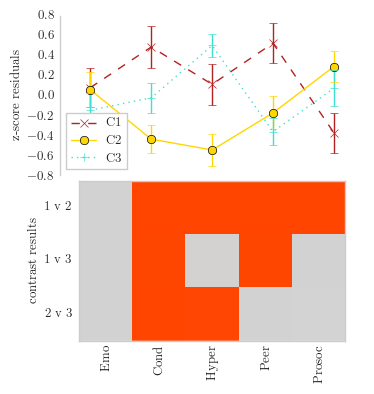

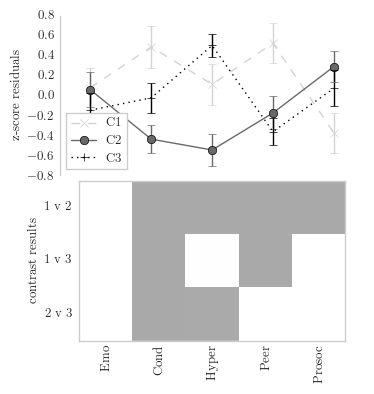

In [683]:
df = merged_df[np.hstack(['groups', SDQ_measures])]
labels = ['Emo', 'Cond', 'Hyper', 'Peer', 'Prosoc']
colours = ['firebrick', 'gold', 'turquoise']
make_SuePlot(df, SDQ_measures, labels, [90*mm2inches, 95*mm2inches], 'SDQ', binarized_results, colours, 0, 1)

colours = ['lightgray', 'dimgray', 'black']
make_SuePlot(df, SDQ_measures, labels, [90*mm2inches, 95*mm2inches], 'SDQ_bwr', binarized_results, colours, 1, 1)

### BRIEF

In [670]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
BRIEF_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']]

merged_df = pd.merge(group_df, BRIEF_df, on='ID').dropna()
BRIEF_measures = ['Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']
merged_df[BRIEF_measures] = scaler.fit_transform(merged_df[BRIEF_measures])

In [671]:
results = pd.DataFrame()
group_comparisons = [(1,2), (1,3), (2,3)]

for BRIEF_measure in BRIEF_measures:
    for group_comparison in group_comparisons:
        t,p = ttest_ind(merged_df[merged_df['groups'] == group_comparison[0]][BRIEF_measure].values.astype('int'), merged_df[merged_df['groups'] == group_comparison[1]][BRIEF_measure].values.astype('int'))
        results.set_value(BRIEF_measure, str(group_comparison), p)

In [672]:
results

,"(1, 2)","(1, 3)","(2, 3)"
Brief_Inhibit_raw,0.000003,0.130197,7.297262e-09
Brief_Shift_raw,0.842705,0.035655,1.806073e-02
Brief_Emotional_Control_raw,0.221073,0.001116,8.809389e-06
Brief_Initiate_raw,0.289084,0.585704,1.552493e-01
Brief_Working_Memory_raw,0.000975,0.000106,2.737064e-01
Brief_Planning_raw,0.008165,0.132261,3.676987e-01
Brief_Organisation_raw,0.000003,0.017534,4.702048e-02
Brief_Monitor_raw,0.000287,0.853976,1.386454e-03


In [673]:
rej, p, alphaSidak, alphaBonferroni = multipletests(results.values.flatten(), alpha=0.05, method='bonferroni')
binarized_results = 1*(results.values < alphaBonferroni).transpose()

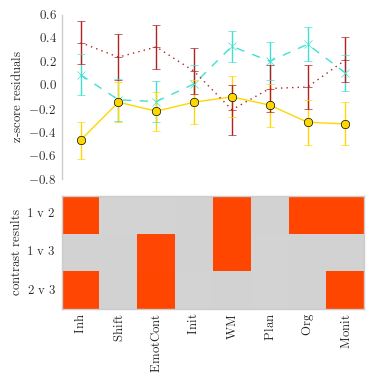

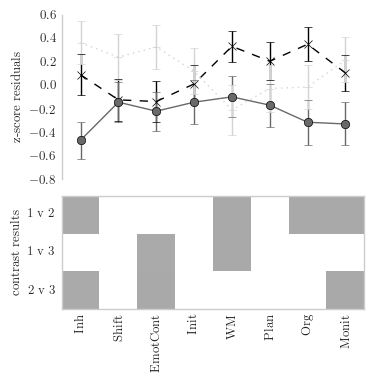

In [676]:
df = merged_df[np.hstack(['groups', BRIEF_measures])]
labels = ['Inh', 'Shift', 'EmotCont', 'Init', 'WM', 'Plan', 'Org', 'Monit']
colours = ['turquoise', 'gold', 'firebrick']
make_SuePlot(df, BRIEF_measures, labels, [90*mm2inches, 95*mm2inches], 'BRIEF', binarized_results, colours, 0, 0)

colours = ['black', 'dimgray', 'lightgray']
make_SuePlot(df, BRIEF_measures, labels, [90*mm2inches, 95*mm2inches], 'BRIEF_bwr', binarized_results, colours, 1, 0)

## Characterising performance IQ in the whole sample

In [184]:
group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Apr17.csv')
IQ_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Apr17.csv')[['ID No.', 'Matrix_Reasoning_T']]
IQ_df.columns = ['ID', 'Matrix_Reasoning_T']
merged_df = pd.merge(group_df, IQ_df, on='ID').dropna()

In [186]:
merged_df.shape

(432, 14)

In [185]:
mean = np.mean(merged_df['Matrix_Reasoning_T'])
std = np.std(merged_df['Matrix_Reasoning_T'])
print('Matrix Reasoning: mean=%.2f, std=%.3f' % (mean, std))

Matrix Reasoning: mean=42.68, std=9.282


In [187]:
total = np.sum(1*(merged_df['Matrix_Reasoning_T'] < 40))
percentage = float(total)/len(merged_df['Matrix_Reasoning_T'])
print('Low range= %.2f (%.2f)' % (total, percentage))

Low range= 173.00 (0.40)


### Descriptive statistics of the clusters

In [410]:
df = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')

In [405]:
for group in [1,2,3]:
    observed = list(df[df['groups'] == group]['gender'].value_counts()/len(df[df['groups'] == group]))
    expected = list(df['gender'].value_counts()/len(df))
    chi,p = chisquare(observed, expected)
    print('Chi-squared: %.2f, p=%.3f' % (chi,p))

Chi-squared: 0.01, p=0.934
Chi-squared: 0.08, p=0.771
Chi-squared: 0.04, p=0.842


In [412]:
df['age'] = df['age']/12
df.groupby('groups')['age'].mean().round(2)
df.groupby('groups')['age'].std().round(3)

groups
1    2.437
2    2.143
3    2.023
Name: age, dtype: float64

In [413]:
for grouping in [[1,2], [1,3], [2,3]]:
    group1 = df[df['groups'] == grouping[0]]['age'].values
    group2 = df[df['groups'] == grouping[1]]['age'].values
    t,p = ttest_ind(group1, group2)
    print('t=%.2f, p=%.3f' % (t,p))

t=-0.02, p=0.981
t=1.03, p=0.304
t=1.12, p=0.263


## Comparing diagnoses between groups

In [44]:
df_woAge = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')
diag_df = pd.read_csv(outfolder + 'CALM_referrer_codes_Apr2017.csv')
diag_df = diag_df[['ID No.','Diagnosis', 'Referrer_Code']]
diag_df.columns = ['ID', 'Diagnosis', 'Referrer_Code']
diag_df = diag_df.dropna()
diag_df = pd.merge(df_woAge, diag_df, on='ID')

In [45]:
diagnostic_label = list()

for entry in diag_df['Diagnosis'].values:
    if entry in (2, 3, 22, 26, 27, 27, 28, 29, 30, 31, 34, 35):
        diagnostic_label.append('ADHD')
    elif entry in (7, 8, 9, 10, 11, 12, 13, 14, 15):
        diagnostic_label.append('Learning Deficit')
    elif entry in (24,25,23,20):
        diagnostic_label.append('ASD')
    elif entry in (float(nan), 0):
        diagnostic_label.append('None')
    else:
        diagnostic_label.append('Other')

diag_df['Label'] = diagnostic_label

In [46]:
referrer_label = list()

for entry in diag_df['Referrer_Code'].values:
    if entry == 1:
        referrer_label.append('SENCo')
    elif entry == 2:
        referrer_label.append('Specialist Teacher')
    elif entry == 3:
        referrer_label.append('Educational Psychologist')
    elif entry == 4:
        referrer_label.append('Speech and Language Therapist')
    elif entry == 5:
        referrer_label.append('Clinical Psychologist')
    elif entry == 6:
        referrer_label.append('Child Psychiatrist')
    elif entry == 7:
        referrer_label.append('Paediatrician')
    elif entry == 8:
        referrer_label.append('ADHD Nurse Practitioner')
    elif entry == 9:
        referrer_label.append('Family worker locality team')
    elif entry == 11:
        referrer_label.append('Private tutor')
    else: 
        referrer_label.append('None')
        
diag_df['Referrer'] = referrer_label

In [56]:
referrer_breakdown = pd.DataFrame(diag_df['Referrer'].value_counts())
referrer_breakdown['Percentage'] = 100*(referrer_breakdown['Referrer'].values.astype('float')/390).round(3)
print(referrer_breakdown.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Referrer &  Percentage \\
\midrule
SENCo                         &       261 &        66.9 \\
Paediatrician                 &        82 &        21.0 \\
Clinical Psychologist         &        29 &         7.4 \\
Speech and Language Therapist &        29 &         7.4 \\
Specialist Teacher            &        13 &         3.3 \\
ADHD Nurse Practitioner       &        13 &         3.3 \\
Educational Psychologist      &         6 &         1.5 \\
Family worker locality team   &         5 &         1.3 \\
Child Psychiatrist            &         2 &         0.5 \\
Private tutor                 &         1 &         0.3 \\
\bottomrule
\end{tabular}



In [20]:
diagnosis_breakdown = pd.DataFrame(diag_df['Label'].value_counts())
diagnosis_breakdown['Percentage'] = 100*(diagnosis_breakdown['Label'].values.astype('float')/390).round(3)
print(diagnosis_breakdown.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Label &  Percentage \\
\midrule
None               &    299 &        76.7 \\
ADD/ADHD           &     61 &        15.6 \\
Learning Deficit   &     32 &         8.2 \\
ASD                &     24 &         6.2 \\
Other              &     23 &         5.9 \\
Anxiety/Depression &      1 &         0.3 \\
OCD                &      1 &         0.3 \\
\bottomrule
\end{tabular}



### Comparing frequency of diagnoses between groups

In [58]:
group_counts = np.asarray(diag_df.groupby('groups')['Label'].value_counts().tolist())

In [59]:
for i in np.arange(0, len(np.unique(diag_df['Label'].values))-3):
    observed_values = group_counts[np.arange(i, len(group_counts)-1, len(np.unique(diag_df['Label'].values))-1)]
    predicted_values = np.repeat(float(np.sum(observed_values))/len(np.unique(diag_df['groups'].values)), len(np.unique(diag_df['groups'].values)))
    chisq, p = chisquare(observed_values, predicted_values)
    print(np.unique(diag_df['Label'])[i])
    print('$X^2$(%i,%i)=%.2f, $p$=%.3f' % (len(np.unique(diag_df['groups'])), 354, chisq, p))

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [66]:
diag_df.groupby('groups')['Label'].value_counts()

groups  Label           
1       None                 93
        ADD/ADHD             33
        ASD                  13
        Other                 8
        Learning Deficit      3
2       None                105
        Learning Deficit     22
        Other                 8
        ASD                   5
        ADD/ADHD              4
3       None                101
        ADD/ADHD             24
        Other                 9
        Learning Deficit      7
        ASD                   6
dtype: int64

## Plot of profiles by diagnostic groups

In [76]:
std_df['groups'] = diag_df['Label'].values

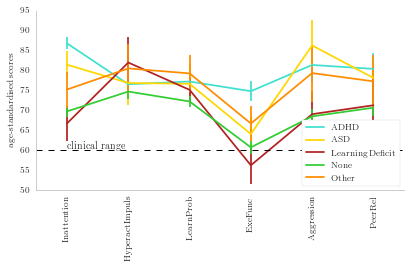

In [95]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'deepskyblue']

plt.figure(figsize=(one_half_column, single_column), dpi=300)

counter = 0
for community in np.unique(std_df['groups']):
    plt.errorbar(x=range(0,len(std_df.columns[2:-1].values)),
                 y=std_df[std_df['groups'] == community].mean()[2:].values,
                 yerr=2*std_df[std_df['groups'] == community][std_df.columns[2:-1]].apply(sem).values,
                 color=colours[counter])
    counter += 1

plt.legend(np.unique(std_df['groups'].values), frameon=True, loc='lower right')

plt.axhline(y=60, linewidth=1, color='k', linestyle='dashed')
plt.xlim([-0.5,len(df_woAge.columns[4:-3].values)-0.5])
plt.xticks(range(0,len(df_woAge.columns[4:-3].values)))

plt.text(0, 60.5, 'clinical range')
plt.ylabel('age-standardised scores')
ax = plt.gca()
ax.set_xticklabels(df_woAge.columns[4:-3].values, rotation=90);
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig(outfolder + 'diagnostic_groups_scales.png', dpi=300)

## Comparison of variability between data-driven groups and diagnostic groups

In [468]:
def bootstrap_correlations(df):
    
    # Building a bootstrap sample of correlations
    means = []

    for i in np.arange(1000):
        sub_df = df.copy()
        sub_df = sub_df[sub_df.index.isin(np.random.choice(sub_df.index, size=15))]
        means.append(sub_df.transpose().corr().mean().mean())

    return np.asarray(means)

In [440]:
def compare_correlations(df, scales, name):
    df = pd.merge(diag_df[['ID', 'age', 'groups', 'Label']], df[np.hstack(['ID', scales])], on='ID').dropna()
    
    for scale in scales:
        df[scale] = ols('y ~ X', data=pd.DataFrame({'X': df['age'].values, 'y':df[scale].values})).fit().resid.values

    df[scales] = df[scales].astype('float64').apply(zscore)

    data_groups = [bootstrap_correlations(df[df['groups'] == group][scales]) for group in [1, 2, 3]]
    diagnostic_groups = [bootstrap_correlations(df[df['Label'] == group][scales]) for group in ['ADHD', 'ASD', 'Learning Deficit', 'Other']]

    mean_data = np.mean(np.asarray(data_groups), axis=0)
    mean_diag = np.mean(np.asarray(diagnostic_groups), axis=0)
    

    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                   'font.family': [u'serif'],
                   'font.sans-serif': [u'Computer Modern Unicode'],})

    plt.figure(figsize=(double_column/2, double_column/2), dpi=300)
    sns.kdeplot(mean_data, color='lightseagreen', shade=True, label='data-driven grouping')
    sns.kdeplot(mean_diag, color='coral', shade=True, label='diagnostic grouping')
    plt.xlabel('Pearson correlation coefficient [$R$]')

    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.savefig('/imaging/jb07/CALM/Behavioural/Community_Detection/' + name + '.png', dpi=300)

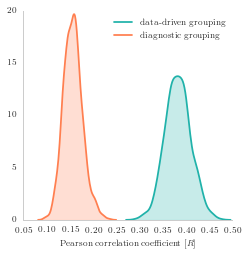

In [441]:
Conners_df = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')
scales = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
compare_correlations(Conners_df, scales, 'Conners_similarity')

### Inter-participant similarity for the BRIEF questionnaire

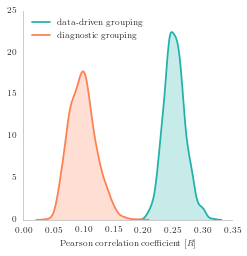

In [437]:
BRIEF_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']]
scales = ['Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']
compare_correlations(BRIEF_df, scales, 'BRIEF_similarity')

### Inter-participant similarity for the SDQ questionnaire

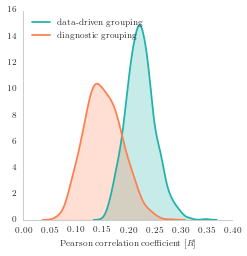

In [439]:
SDQ_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']]
scales = ['SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']
compare_correlations(SDQ_df, scales, 'SDQ_similarity')

In [469]:
def compare_correlations(df, scales, name):
    df = pd.merge(diag_df[['ID', 'age', 'groups', 'Label']], df[np.hstack(['ID', scales])], on='ID').dropna()
    
    for scale in scales:
        df[scale] = ols('y ~ X', data=pd.DataFrame({'X': df['age'].values, 'y':df[scale].values})).fit().resid.values

    df[scales] = df[scales].astype('float64').apply(zscore)

    data_groups = [bootstrap_correlations(df[df['groups'] == group][scales]) for group in [1, 2, 3]]
    diagnostic_groups = [bootstrap_correlations(df[df['Label'] == group][scales]) for group in ['ADHD', 'ASD', 'Learning Deficit', 'Other']]

    mean_data = np.mean(np.asarray(data_groups), axis=0)
    mean_diag = np.mean(np.asarray(diagnostic_groups), axis=0)
    
    return mean_data - mean_diag

In [470]:
Conners_df = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')
scales = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
differences = compare_correlations(Conners_df, scales, 'Conners_similarity')

p = float(1+ np.sum(1*(differences < 0)))/(1+ len(differences))
print('Boot-strap differences: mean=%.2f, SE=%.3f, p=%.3f' % (np.mean(differences), sem(differences), p))

Boot-strap differences: mean=0.22, SE=0.002, p=0.001


In [471]:
BRIEF_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']]
scales = ['Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']
differences = compare_correlations(BRIEF_df, scales, 'BIREF_similarity')

p = float(1+ np.sum(1*(differences > 0)))/(1+ len(differences))
print('Boot-strap differences: mean=%.2f, SE=%.3f, p=%.3f' % (np.mean(differences), sem(differences), p))

Boot-strap differences: mean=-0.15, SE=0.001, p=0.002


In [472]:
SDQ_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']]
scales = ['SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']
differences = compare_correlations(SDQ_df, scales, 'SDQ_similarity')

p = float(1+ np.sum(1*(differences > 0)))/(1+ len(differences))
print('Boot-strap differences: mean=%.2f, SE=%.3f, p=%.3f' % (np.mean(differences), sem(differences), p))

Boot-strap differences: mean=-0.07, SE=0.002, p=0.173


## Comparison of results to PCA

In [249]:
conners_df = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')
scales = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
conners_df = conners_df[scales]

Creating a plot of the correlation matrix

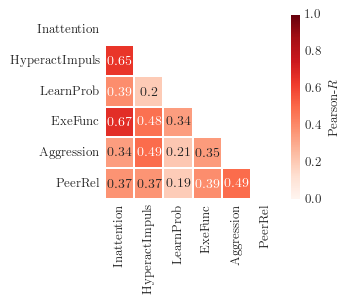

In [283]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

plt.figure(figsize=(90*mm2inches, 80*mm2inches), dpi=600)

corr = conners_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(conners_df.corr(),
            annot=True,
            cbar_kws={"label": "Pearson-$R$"},
            cmap='Reds',
            linewidth=.5,
            mask=mask,
            vmin=0, vmax=1)
plt.tight_layout()
plt.savefig(outfolder + '/correlation_matrix.png', dpi=600)

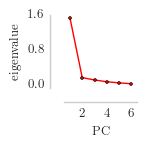

In [315]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

plt.figure(figsize=(40*mm2inches, 40*mm2inches), dpi=600)
U, S, V = np.linalg.svd(corr) 
eigvals = S**2 / np.cumsum(S)[-1]
sing_vals = np.arange(len(scales)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=1, markersize=2)
plt.xlim([0.5, 6.5])
plt.ylim([-.1, 1.6])
ax = plt.gca()
ax.set_yticks(np.linspace(0, 1.6, 3))
ax.set_xticks([2, 4, 6])
sns.despine(offset=10);
plt.xlabel('PC')
plt.ylabel('eigenvalue')
plt.tight_layout()
plt.savefig(outfolder + '/scree_plot.png', dpi=600)

In [317]:
conners_df.to_csv(outfolder + '/Conners_data_for_PCA.csv', index=False)

The principal component analysis was carried out in R, because there was a well-validated and accessible implementation of PCA with factor rotation

In [ ]:
"""`R
require(psych)
data <- read.csv("//cbsu/data/imaging_new/jb07/CALM/Behavioural/Community_Detection/Conners_data_for_PCA.csv")
principal(cor(data), nfactors=2, rotate='varimax')
principal(cor(data), nfactors=3, rotate='varimax')
"""

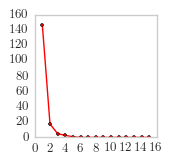

In [350]:
corr = conners_df.transpose().corr()
U, S, V = np.linalg.svd(corr) 
eigvals = S**2 / np.cumsum(S)[-1]
sing_vals = np.arange(len(corr)) + 1
plt.figure(figsize=(40*mm2inches, 40*mm2inches), dpi=600)
plt.plot(sing_vals[0:15], eigvals[0:15], 'ro-', linewidth=1, markersize=2)

### Item responses

In [438]:
original_IDs = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')['ID'].values
df = pd.read_csv(outfolder + 'Conners_item_responses.csv')
df = df[df['ID'].isin(original_IDs)]
df = df.set_index('ID')
df = df.dropna()
df = df[df.columns].astype(str).convert_objects(convert_numeric=True)

/home/jb07/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


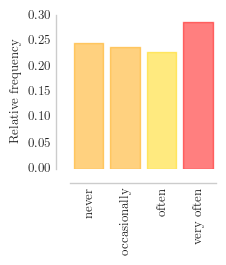

In [519]:
counts = pd.melt(df)['value'].value_counts(normalize=True, sort=False)[0:4].values
y_pos = [0, 1, 2, 3]

plt.figure(figsize=(60*mm2inches, 70*mm2inches), dpi=600)
barlist = plt.bar(y_pos, counts, align='center', alpha=0.5)
barlist[0].set_color('orange')
barlist[1].set_color('orange')
barlist[2].set_color('gold')
barlist[3].set_color('red')
sns.despine(offset=10);
ax = plt.gca()
ax.set_xticks([0, 1, 2, 3]);
ax.set_xticklabels(['never', 'occasionally', 'often', 'very often'], rotation=90);
plt.ylabel('Relative frequency')
plt.tight_layout()
plt.savefig('/home/jb07/Desktop/Item_frequencies.png', dpi=600)

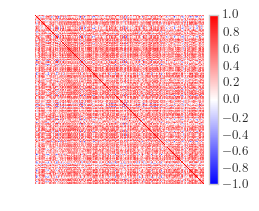

In [535]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(60*mm2inches, 60*mm2inches), dpi=600)

im = plt.imshow(df.transpose().corr(), interpolation='None', vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.yaxis.set_label_position('right')
plt.savefig('/home/jb07/Desktop/Item_correlation.png', dpi=600)

### Clustering with more than one measure

In [631]:
group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
BRIEF_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']]
df = pd.merge(group_df, BRIEF_df, left_on='ID', right_on='ID')
df = df.dropna()
df[scales] = df[scales].astype('float64').apply(zscore)

Conners_scales = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
BRIEF_scales = BRIEF_df.columns[1:]
scales = np.hstack([Conners_scales, BRIEF_scales])

In [632]:
corr = df[scales].transpose().corr()

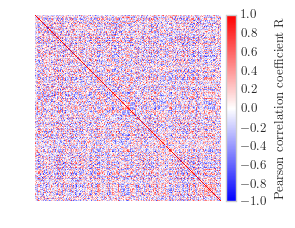

In [644]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=600)

im = plt.imshow(corr, interpolation='None', vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.yaxis.set_label_position('right')
cb.set_label('Pearson correlation coefficient R')
plt.tight_layout(pad=0, w_pad=1, h_pad=0)

In [ ]:
network,df_woAge = construct_network(df[np.hstack([['age'], scales])])

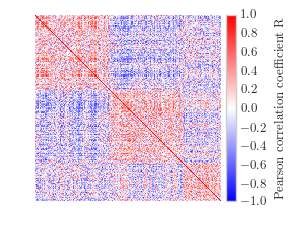

In [642]:
community_affiliation,q = get_consensus_module_assignment(network, 100)
plot_community_matrix(network, community_affiliation, 'bwr')

In [637]:
df_woAge['groups'] = community_affiliation

In [638]:
results = pd.DataFrame()
group_comparisons = [(1,2), (1,3), (2,3)]

for scale in scales:
    for group_comparison in group_comparisons:
        t,p = ttest_ind(df_woAge[df_woAge['groups'] == group_comparison[0]][scale].values.astype('int'), df_woAge[df_woAge['groups'] == group_comparison[1]][scale].values.astype('int'))
        results.set_value(scale, str(group_comparison), p)
        
rej, p, alphaSidak, alphaBonferroni = multipletests(results.values.flatten(), alpha=0.05, method='bonferroni')
binarized_results = 1*(results.values < alphaBonferroni).transpose()

In [639]:
import re
labels = []
for scale in scales:
    if not re.search('Brief', scale):
        label = 'Conners ' + scale
    else:
        label = 'BRIEF ' + scale.split('_')[1]
    labels.append(label)

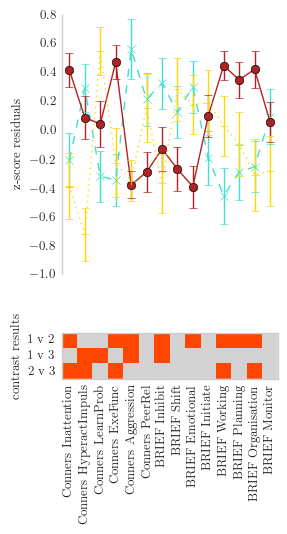

In [647]:
df = df_woAge[np.hstack(['groups', scales])]
colours = ['turquoise', 'firebrick', 'gold']
make_SuePlot(df, scales, labels, [68*mm2inches, 139*mm2inches], 'BRIEF', binarized_results, colours, 0, 0)

## Clustering with a different algorithm

In [650]:
scales = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
network,df_woAge = construct_network(df[np.hstack([['age'], scales])])

In [662]:
community_affiliation1, q = bct.modularity_finetune_und_sign(network)

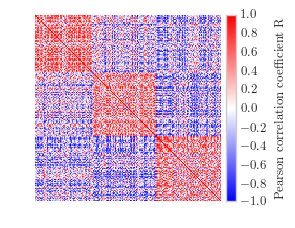

In [668]:
plot_community_matrix(network, community_affiliation, 'bwr')
plt.savefig('/home/jb07/Desktop/modularity1.png', dpi=600)

In [661]:
community_affiliation2,q = get_consensus_module_assignment(network, 100)

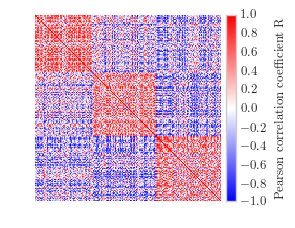

In [669]:
plot_community_matrix(network, community_affiliation, 'bwr')
plt.savefig('/home/jb07/Desktop/modularity2.png', dpi=600)

In [665]:
normalized_variation, normalized_mutual_info = bct.partition_distance(community_affiliation1, community_affiliation2)

In [666]:
normalized_variation

0.0

In [667]:
normalized_mutual_info

1.0

## Custom plot

In [28]:
df = pd.read_csv(outfolder + 'Behavioural_data_grouped_Apr17.csv')
df[measures] = zscore(df[measures].values)
measures = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
colours = ['turquoise', 'firebrick', 'gold']

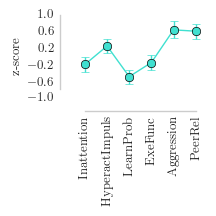

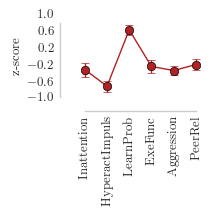

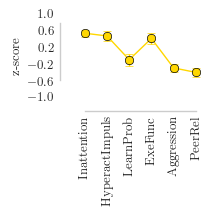

In [41]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'sansserif'],
               'font.sans-serif': [u'Verdana'],})
styles = [['o', 'solid'], ['o', 'solid'], ['o', 'solid']]


for community in np.unique(df['groups'].values):
    fig = plt.figure(figsize=(50*mm2inches, 50*mm2inches), dpi=600)
    plt.errorbar(x=range(0,len(measures)),
            y=df[df['groups'] == community][measures].mean().values,
            yerr=2*df[df['groups'] == community][measures].std().values/sqrt(len(df[df['groups'] == community])),
            color=colours[community-1],
            marker=styles[community-1][0],
            linestyle=styles[community-1][1])

    plt.xlim([-0.5,len(measures)-0.5])
    plt.xticks(range(0,len(measures)))
    plt.ylabel('z-score')
    sns.despine(offset=10, trim=True)  
    ax = plt.gca()
    ax.set_yticks(np.arange(-1, 1.2, 0.4))
    ax.set_xticklabels(measures, rotation=90);
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.savefig(outfolder + 'separate_Sue_plots' + str(community) + '.png', dpi=600)